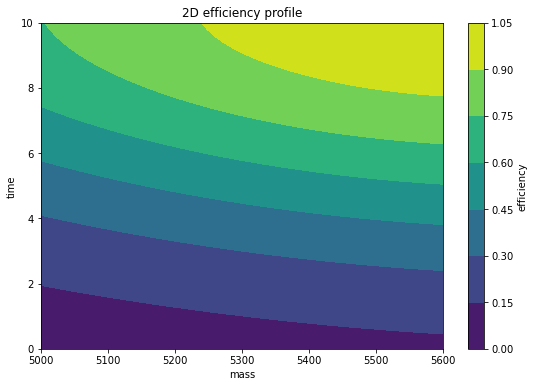

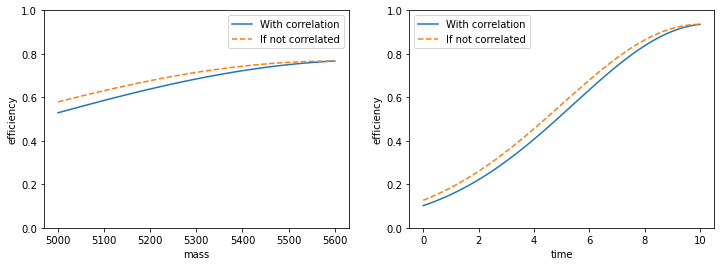

In [1]:
### We are now going to see what happens with the practical example when we introduce an efficiency term

import numpy as np
from scipy import stats
from scipy.stats import norm, expon, powerlaw, multivariate_normal, chi2
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from scipy.integrate import quad, dblquad, nquad

np.random.seed(1)  # fix seed

# true parameters for signal and background
truth_n_sig = 500
truth_n_bkg = 2000

# signal mass gauss:(mean, sigma)
truth_sig_m = (5280, 30)
# background mass expo:(loc, scale)
truth_bkg_m = (5000,400,)
# signal time expo:(loc, scale)
truth_sig_t = (0, 2.0,)
# background time gauss:(mean, sigma)
truth_bkg_t = (0., 3.0)

# make the pdfs
sig_pdf_mass = norm(*truth_sig_m)
bkg_pdf_mass = expon(*truth_bkg_m)
sig_pdf_time = expon(*truth_sig_t)
bkg_pdf_time = norm(*truth_bkg_t)

# eff func
eff_means  = [ 5600, 10 ]
eff_sigmas = [ 800 , 5 ]
eff_corr = -0.2
eff_cov = [ [ eff_sigmas[0]**2, eff_corr*eff_sigmas[0]*eff_sigmas[1] ],
            [ eff_corr*eff_sigmas[0]*eff_sigmas[1], eff_sigmas[1]**2 ]
          ]

eff_pdf = multivariate_normal(eff_means, eff_cov)



# plot the pdfs
mrange = (5000,5600)
trange = (0,10)
mass = np.linspace(*mrange,50)
time = np.linspace(*trange,50)

fig, ax = plt.subplots(1,1,figsize=(9,6))
x,y = np.meshgrid(mass,time)
eff_norm = np.max( eff_pdf.pdf(np.dstack((x,y))) )

im = ax.contourf(x,y, eff_pdf.pdf(np.dstack((x,y)))/eff_norm)
cb = fig.colorbar(im, ax=ax)
ax.set_xlabel('mass')
ax.set_ylabel('time')
cb.set_label('efficiency')
ax.set_title("2D efficiency profile")

# for each mass value want to project the PDF so need it's expectation in the other dimension

fig, ax = plt.subplots(1,2,figsize=(12,4))
expected_ms = []
expected_ts = []

for m in mass:
    # get expectation value of t at given mass m
    exp_norm = quad( lambda t: eff_pdf.pdf([m,t]), *trange )[0]
    exp_val  = quad( lambda t: t*eff_pdf.pdf([m,t])/exp_norm, *trange )[0]
    expected_ts.append( exp_val )

for t in time:
    # get expectation value of m at given time t
    exp_norm = quad( lambda m: eff_pdf.pdf([m,t]), *mrange )[0]
    exp_val  = quad( lambda m: m*eff_pdf.pdf([m,t])/exp_norm, *mrange )[0]
    expected_ms.append( exp_val )
    
expected_ms = np.array( expected_ms )
expected_ts = np.array( expected_ts)

# make the relevant mesh
mass_w_texp = np.dstack((mass,expected_ts))
time_w_mexp = np.dstack((expected_ms,time))

ax[0].plot(mass, eff_pdf.pdf(mass_w_texp)/eff_norm,label='With correlation')
mcheck = norm(eff_means[0],eff_sigmas[0])
mcn = np.max(eff_pdf.pdf(mass_w_texp)/eff_norm) / np.max(mcheck.pdf(mass))
ax[0].plot(mass, mcn*mcheck.pdf(mass), '--', label='If not correlated')
ax[0].set_ylim(0,1)
ax[0].set_xlabel('mass')
ax[0].set_ylabel('efficiency')
ax[0].legend()


ax[1].plot(time, eff_pdf.pdf(time_w_mexp)/eff_norm,label='With correlation')
tcheck = norm(eff_means[1],eff_sigmas[1])
tcn = np.max(eff_pdf.pdf(time_w_mexp)/eff_norm) / np.max(tcheck.pdf(time))
ax[1].plot(time, tcn*tcheck.pdf(time), '--',label='If not correlated')
ax[1].set_ylim(0,1)
ax[1].set_xlabel('time')
ax[1].set_ylabel('efficiency')
ax[1].legend()



Text(0.5, 1.0, 'Time efficiency projection')

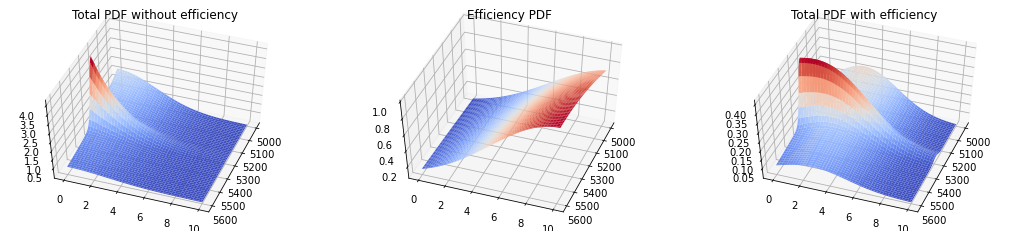

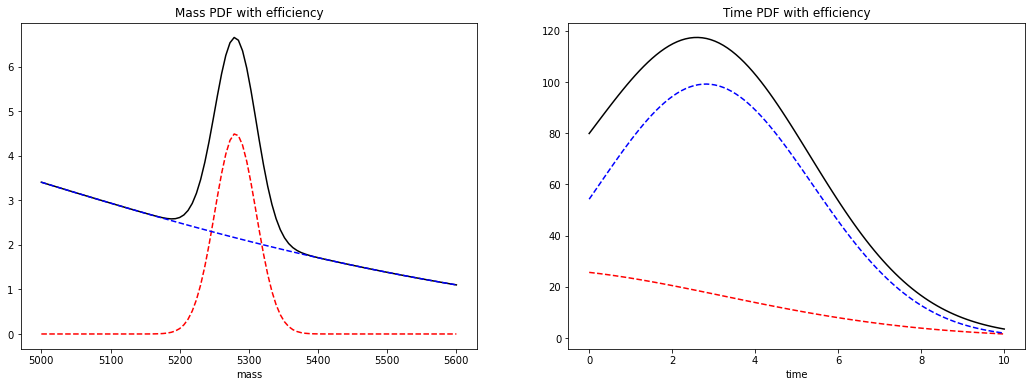

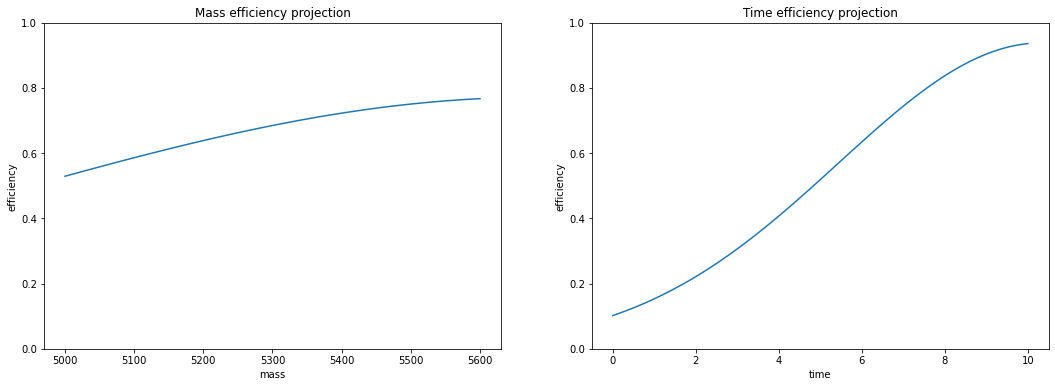

In [2]:
from matplotlib import gridspec
from matplotlib import cm

# get the normalisation for the range
sig_norm_mass = np.diff(sig_pdf_mass.cdf(mrange))
bkg_norm_mass = np.diff(bkg_pdf_mass.cdf(mrange))
sig_norm_time = np.diff(sig_pdf_time.cdf(trange))
bkg_norm_time = np.diff(bkg_pdf_time.cdf(trange))

# get the efficiency normalised back to one also
#range2d = np.dstack( (mrange,trange) )
#eff_norm = np.diff( eff_pdf.cdf( range2d ) )
#print(np.diff( eff_pdf.cdf( range2d )/eff_norm ) )

### now plot the pdf with the efficiency included
def pdf(x, y, eff=True, sonly=False, bonly=False):
    sig_term = truth_n_sig * sig_pdf_mass.pdf(x)/sig_norm_mass * sig_pdf_time.pdf(y)/sig_norm_time
    bkg_term = truth_n_bkg * bkg_pdf_mass.pdf(x)/bkg_norm_mass * bkg_pdf_time.pdf(y)/bkg_norm_time
    sum_term = sig_term + bkg_term
    if sonly: sum_term = sig_term
    if bonly: sum_term = bkg_term
    if eff: return eff_pdf.pdf(np.dstack((x,y)))/eff_norm * sum_term
    else: return sum_term

# get expectation value of t at given mass m
def expt(m):
    evals = np.empty(m.shape)
    for i, v in enumerate(m):
        exp_norm = quad( lambda t: eff_pdf.pdf([v,t]), *trange )[0]
        exp_val  = quad( lambda t: t*eff_pdf.pdf([v,t])/exp_norm, *trange )[0]
        evals[i] = exp_val
    return evals

# get expectation value of m at given time t
def expm(t):
    evals = np.empty(t.shape)
    for i, v in enumerate(t):
        exp_norm = quad( lambda m: eff_pdf.pdf([m,v]), *mrange )[0]
        exp_val  = quad( lambda m: m*eff_pdf.pdf([m,v])/exp_norm, *mrange )[0]
        evals[i] = exp_val
    return evals
    
def pdf_proj(x, axis='x', eff=True, sonly=False, bonly=False, eonly=False):
    assert(axis=='x' or axis=='y' or axis=='m' or axis=='t')
    if axis=='x' or axis=='m':
        sig_term = truth_n_sig * sig_pdf_mass.pdf(x)/sig_norm_mass
        bkg_term = truth_n_bkg * bkg_pdf_mass.pdf(x)/bkg_norm_mass
    elif axis=='y' or axis=='t':
        sig_term = truth_n_sig * sig_pdf_time.pdf(x)/sig_norm_time
        bkg_term = truth_n_bkg * bkg_pdf_time.pdf(x)/bkg_norm_time
    else: return -1
    
    sum_term = sig_term + bkg_term
    if sonly: sum_term = sig_term
    if bonly: sum_term = bkg_term
    if eonly: sum_term = 1.
    if eff: 
        if   axis=='x' or axis=='m': vals = np.dstack((x,expt(x)))
        elif axis=='y' or axis=='t': vals = np.dstack((expm(x),x))
        else: return -1
        return eff_pdf.pdf(vals)/eff_norm * sum_term
    else: return sum_term
        
fig = plt.figure(figsize=(18,4))
gs = gridspec.GridSpec(1, 3)

mass = np.linspace(*mrange,100)
time = np.linspace(*trange,100)

x, y  = np.meshgrid( mass, time )

ax   = fig.add_subplot(gs[0], projection='3d')
ax.plot_surface(x,y,pdf(x,y, eff=False), cmap=cm.coolwarm)
ax.view_init(50,20)
ax.set_title('Total PDF without efficiency')

ax   = fig.add_subplot(gs[1], projection='3d')
ax.plot_surface(x,y,eff_pdf.pdf(np.dstack((x,y)))/eff_norm, cmap=cm.coolwarm)
ax.view_init(50,20)
ax.set_title('Efficiency PDF')

ax   = fig.add_subplot(gs[2], projection='3d')
ax.plot_surface(x,y,pdf(x,y), cmap=cm.coolwarm)
ax.view_init(50,20)
ax.set_title('Total PDF with efficiency')

fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot( mass, pdf_proj(mass, axis='m'), 'k-' )
ax[0].plot( mass, pdf_proj(mass, axis='m', sonly=True), 'r--' )
ax[0].plot( mass, pdf_proj(mass, axis='m', bonly=True), 'b--' )
ax[0].set_xlabel('mass')
ax[0].set_title('Mass PDF with efficiency')

ax[1].plot( time, pdf_proj(time, axis='t'), 'k-' )
ax[1].plot( time, pdf_proj(time, axis='t', sonly=True), 'r--' )
ax[1].plot( time, pdf_proj(time, axis='t', bonly=True), 'b--' )
ax[1].set_xlabel('time')
ax[1].set_title('Time PDF with efficiency')

fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot( mass, pdf_proj(mass, axis='m', eonly=True))
ax[0].set_ylim(0,1)
ax[0].set_xlabel('mass')
ax[0].set_ylabel('efficiency')
ax[0].set_title('Mass efficiency projection')

ax[1].plot( time, pdf_proj(time, axis='t', eonly=True))
ax[1].set_ylim(0,1)
ax[1].set_xlabel('time')
ax[1].set_ylabel('efficiency')
ax[1].set_title('Time efficiency projection')


In [3]:
### make a toy

## generate some toy data
truth_n_bkg = 20000
truth_n_sig = 5000
truth_n_tot = truth_n_bkg + truth_n_sig
data = np.empty( (truth_n_tot,2) )

# fill sig vals
nsig = 0
while nsig < truth_n_sig:
    mval = sig_pdf_mass.rvs(1)[0]
    tval = sig_pdf_time.rvs(1)[0]
    if mval > mrange[1] or mval < mrange[0] or tval > trange[1] or tval < trange[0]: continue
    ## now we need to accept-reject based on the efficiency
    if np.random.uniform() > eff_pdf.pdf([mval,tval])/eff_norm: continue
    data[nsig,0] = mval
    data[nsig,1] = tval
    nsig += 1
    
# fill bkg vals
nbkg = 0
while nbkg < truth_n_bkg:
    mval = bkg_pdf_mass.rvs(1)[0]
    tval = bkg_pdf_time.rvs(1)[0]
    if mval > mrange[1] or mval < mrange[0] or tval > trange[1] or tval < trange[0]: continue
    ## now we need to accept-reject based on the efficiency
    if np.random.uniform() > eff_pdf.pdf([mval,tval])/eff_norm: continue
    data[nsig+nbkg,0] = mval
    data[nsig+nbkg,1] = tval
    nbkg += 1
    
# check events are all in range 
subs = ( mrange[0] < data[:,0] ) & ( mrange[1] > data[:,0] ) & ( trange[0] < data[:,1] ) & ( trange[1] > data[:,1] )
assert( len(subs) == len(data) )


[[5.26164731e+03 3.17419190e-01]
 [5.27482715e+03 6.33491776e+00]
 [5.29507483e+03 8.99462159e+00]
 ...
 [5.32410701e+03 5.18319540e-01]
 [5.21221769e+03 1.26840602e-01]
 [5.10618507e+03 5.13140527e+00]]


/Users/matt/anaconda3/envs/hepenv/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


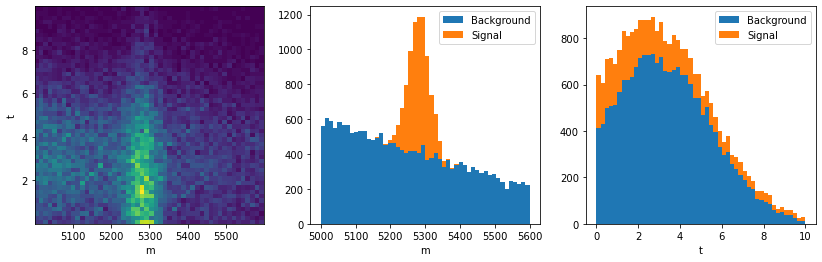

In [4]:
# now plot the generated samples
print(data)
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].hist2d(data[:,0], data[:,1], bins=(50, 50))
ax[0].set_xlabel("m")
ax[0].set_ylabel("t")
ax[1].hist((data[truth_n_sig:,0], data[:truth_n_sig,0]), bins=50, stacked=True, label=("Background", "Signal"))
ax[1].set_xlabel("m")
ax[1].legend()
ax[2].hist((data[truth_n_sig:,1], data[:truth_n_sig,1]), bins=50, stacked=True, label=("Background", "Signal"))
ax[2].set_xlabel("t")
ax[2].legend()

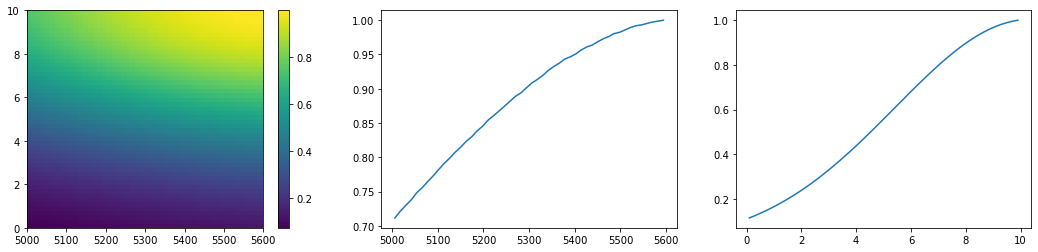

In [69]:
### This is some stuff on binning our efficiency model
import boost_histogram as bh
bins = 50
eff_hist  = bh.Histogram( bh.axis.Regular(bins,*mrange), bh.axis.Regular(bins,*trange), storage=bh.storage.Mean() )

for xval in eff_hist.axes[0].centers:
    for yval in eff_hist.axes[1].centers:
        #eff_hist[ eff_hist.axes[0].index(xval), eff_hist.axes[1].index(yval) ] = eff_pdf.pdf([xval,yval])/eff_norm
        v = eff_pdf.pdf([xval,yval])/eff_norm 
        eff_hist[ eff_hist.axes[0].index(xval), eff_hist.axes[1].index(yval) ] = bh.accumulators.Mean(np.random.poisson(10000*v),v,v**2)


xe = eff_hist.axes[0].edges
ye = eff_hist.axes[1].edges
w  = eff_hist.view().value
xep, yep = np.meshgrid(xe,ye)


fig, ax = plt.subplots(1,3,figsize=(18,4))
im = ax[0].pcolormesh(xep,yep,w.T)
cb = fig.colorbar(im, ax=ax[0])

eff_m = eff_hist.project(0)
eff_t = eff_hist.project(1)
eff_m /= max(eff_m.view().value)
eff_t /= max(eff_t.view().value)

ax[1].plot( eff_m.axes[0].centers, eff_m.view().value )
ax[2].plot( eff_t.axes[0].centers, eff_t.view().value )



(50,)
(50,)


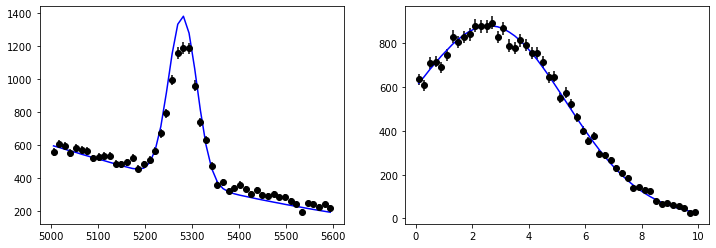

In [70]:
## first we need to get estimates of \hat{g}_s,b

from scipy.interpolate import InterpolatedUnivariateSpline
f_eff_m = InterpolatedUnivariateSpline( eff_m.axes[0].centers, eff_m.view().value, k=3 )
f_eff_t = InterpolatedUnivariateSpline( eff_t.axes[0].centers, eff_t.view().value, k=3 )

bins = 50

mhist = bh.Histogram( bh.axis.Regular(bins,*mrange) )
mhist.fill( data[:,0] )

thist = bh.Histogram( bh.axis.Regular(bins,*trange) )
thist.fill( data[:,1] )

print( mhist.view().shape )
print( eff_m.view().shape )

def mass_pdf(x, sy, sm, ss, by, be):
    sp = norm(sm,ss)
    sn = np.diff(sp.cdf(mrange))
    bp = expon(mrange[0],be)
    bn = np.diff(sp.cdf(mrange))
    n = (mrange[1]-mrange[0])/bins
    y = n*(sy*sp.pdf(x)/sn + by*bp.pdf(x)/bn) * f_eff_m(x)
    ytot = np.sum(y)
    y*= len(data)/ytot
    #assert( x.shape == eff_m.view().shape )
    #return n*(sy*sp.pdf(x)/sn + by*bp.pdf(x)/bn) * f_eff_m(x)
    return y

def time_pdf(x, sy, se, by, bm, bs):
    sp = expon(trange[0],se)
    sn = np.diff(sp.cdf(trange))
    bp = norm(bm,bs)
    bn = np.diff(bp.cdf(trange))
    n = (trange[1]-trange[0])/bins
    y = n*(sy*sp.pdf(x)/sn + by*bp.pdf(x)/bn) * f_eff_t(x)
    ytot = np.sum(y)
    y*= len(data)/ytot
    return y


from iminuit import Minuit
from iminuit.cost import LeastSquares

lst_sqs_m = LeastSquares( mhist.axes[0].centers, mhist.view(), mhist.view()**0.5, mass_pdf)
lst_sqs_t = LeastSquares( thist.axes[0].centers, thist.view(), thist.view()**0.5, time_pdf)

mi_m = Minuit( lst_sqs_m, sy=truth_n_sig, sm=truth_sig_m[0], ss=truth_sig_m[1],
                          by=truth_n_bkg, be=truth_bkg_m[1],
                          fix_sm=True, fix_ss=True, fix_be=True,
                          pedantic=False)

mi_t = Minuit( lst_sqs_t, sy=truth_n_sig, se=truth_sig_t[1],
                          by=truth_n_bkg, bm=truth_bkg_t[0], bs=truth_bkg_t[1],
                          fix_bm=True, fix_bs=True, fix_se=True,
                          pedantic=False)

#mi_m.migrad()
#mi_m.hesse()
#print(mi_m.params)

#mi_t.migrad()
#mi_t.hesse()
#print(mi_t.params)

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].errorbar( mhist.axes[0].centers, mhist.view(), mhist.view()**0.5, fmt='ko' )
mpdf = lambda m: mass_pdf(m, *mi_m.values.values())
ax[0].plot( mhist.axes[0].centers, mpdf(mhist.axes[0].centers), 'b-' )

ax[1].errorbar( thist.axes[0].centers, thist.view(), thist.view()**0.5, fmt='ko' )
tpdf = lambda t: time_pdf(t, *mi_t.values.values())
ax[1].plot( thist.axes[0].centers, tpdf(thist.axes[0].centers), 'b-' )

#print( quad(mpdf, *mrange), len(data) )
#print( quad(tpdf, *trange), len(data) )
#ax[1].plot( hx.axes[0].centers, hx.view().value )


125.0
25000.0 200 600


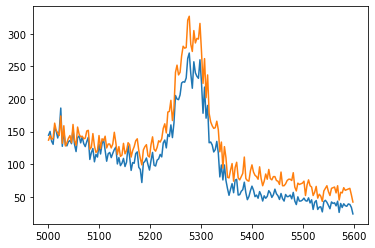

In [98]:
## Now we attempt the weights a. la. Eq(37):

# we need to loop the data and sum all the efficiency weights for each event
# in a given bin (this is not trivial as far as i can tell)
# I think that we can use a boost_histogram which stores a sum and we make sure it
# is passed the weight squared i.e. 1/eps ^2

import boost_histogram as bh
bins = 200

# store the data for n_k
data_hist = bh.Histogram( bh.axis.Regular(bins,*mrange) )
data_hist.fill( data[:,0] )

sw2s = np.zeros(bins)
n_k  = np.zeros(bins)
for m, t in data:
    k = data_hist.axes[0].index(m)
    eff_mind = eff_hist.axes[0].index(m)
    eff_tind = eff_hist.axes[1].index(t)
    e = eff_hist[(eff_mind,eff_tind)].value
    e2 = eff_pdf.pdf([m,t])/eff_norm
    w2 = 1/e #e**(-1)
    sw2s[k] += w2
    n_k[k] += 1

q_k = sw2s / n_k
N_k = np.sum(n_k)
print(N_k/(bins))
print(N_k, bins, mrange[1]-mrange[0])

qk_hist = bh.Histogram( bh.axis.Regular(bins,*mrange), storage=bh.storage.Weight() )
qk_hist.fill( data[:,0], weight=1./(eff_pdf.pdf(data)/eff_norm) )

plt.plot( qk_hist.axes[0].centers, qk_hist.view().variance/data_hist.view() )
plt.plot( qk_hist.axes[0].centers, q_k,'--')

plt.clf()
#plt.plot( data_hist.axes[0].centers, data_hist.view() )
plt.plot( data_hist.axes[0].centers, sw2s/N_k*5000 )
plt.plot( data_hist.axes[0].centers, n_k )
#plt.plot( data_hist.axes[0].centers, ((mrange[1]-mrange[0])/bins)*pdf_proj(data_hist.axes[0].centers, axis='m', eff=False) )
#plt.plot( data_hist.axes[0].centers, ((mrange[1]-mrange[0])/bins)*mpdf(data_hist.axes[0].centers)/3)

# is this really what we expect q(k) to look like -> I'm not convinced (shouldn't it look like our mass shape?)
